In [1]:
import mne
from scipy.io import loadmat
import numpy as np

In [2]:
def file_to_data(fileName):
    chnames = ['Fp1','Fp2','Fc5','Fz','Fc6','T7','Cz','T8','P7','P3','Pz','P4','P8','O1','Oz','O2','stim']
    chtypes = ['eeg'] * 16 + ['stim']
    info = mne.create_info(ch_names=chnames, sfreq=512,ch_types=chtypes, montage='standard_1020',verbose=False)
    data = loadmat(fileName)["SIGNAL"]
    #On modifie pour avoir un dataset avec 1 : yeux ouvert et -1 yeux fermée
    new_data=[]
    yeux_ouvert=False
    for k in range(len(data)):
        if(yeux_ouvert==False):
            tmp=np.append(data[k][1:17],-1)
        else:
            tmp=np.append(data[k][1:17],1)
        new_data.append(tmp)
        if(data[k][17]==1):
            yeux_ouvert=True
        if(data[k][18]==1):
            yeux_ouvert=False
    labels= [d[16] for d in new_data]
    donnees = [d[:16] for d in new_data]
    return donnees,labels

In [3]:
donnees,labels = file_to_data("data/subject_01.mat")

In [4]:
import pyriemann
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

In [5]:
def cross_val_linear(donnees,labels,nb_trail):
    nb_paquet=int(len(donnees)/nb_trail)
    donnees = donnees[:nb_trail*nb_paquet]
    X=np.array(np.split(np.array(donnees), nb_paquet))#Ntrial*Nchannels*Nsample
    X=np.swapaxes(X,1,2)

    X = X.reshape((len(X),16*nb_trail))
    #validation croisée
    clf = SGDClassifier(loss="perceptron", eta0=1e-4, learning_rate="constant", penalty=None,tol=1e-1,max_iter=100000)
    #On modifie les y pour qu'il y est qu'un chiffre tout les 52 enregistrement, on prendra dans un premier temps juste
    #le premier label sur les 52 pour estimer les 52 suivant
    labels = labels[:nb_trail*nb_paquet]
    yTemp = np.array(np.split(np.array(labels), nb_paquet))
    y=np.array([u[0] for u in yTemp])
    accuracy = cross_val_score(clf,X, y,cv=5)
    return (accuracy.mean())

In [13]:
def cross_val_riemann(donnees,labels,nb_trail):
    nb_paquet=int(len(donnees)/nb_trail)
    donnees = donnees[:nb_trail*nb_paquet]
    X=np.array(np.split(np.array(donnees), nb_paquet))#Ntrial*Nchannels*Nsample
    X=np.swapaxes(X,1,2)
    #estimer la matrice de covariance
    cov = pyriemann.estimation.Covariances().fit_transform(X)

    #validation croisée
    mdm = pyriemann.classification.MDM()
    #mdm =  pyriemann.classification.KNearestNeighbor(n_neighbors=10)
    
    #On modifie les y pour qu'il y est qu'un chiffre tout les 52 enregistrement, on prendra dans un premier temps juste
    #le premier label sur les 52 pour estimer les 52 suivant
    labels = labels[:nb_trail*nb_paquet]
    yTemp = np.array(np.split(np.array(labels), nb_paquet))
    y=np.array([u[0] for u in yTemp])
    accuracy = cross_val_score(mdm, cov , y,cv=5)
    return accuracy.mean()

In [15]:
#512 Hz
#On prend 52 trial par échantillon pour avoir un temps de reaction d'environ 0,1015625s
#On supprime les derniers echantillons pour avoir un multiple de 52 et donc des matrices completes
tab_trail=[]
result_acc_linear=[]
result_acc_riemmann=[]
for mult in range(2,50):
    nb_trail=mult*10
    print(nb_trail)
    acc = cross_val_linear(donnees,labels,nb_trail)
    print("accuracy linear : "+str(acc))
    tab_trail.append(nb_trail)
    result_acc_linear.append(acc)
    acc = cross_val_riemann(donnees,labels,nb_trail)
    result_acc_riemmann.append(acc)
    print("accuracy riemann : "+str(acc))

20
accuracy linear : 0.5849749582637729
(5990,)
accuracy riemann : 0.7911519198664441
30
accuracy linear : 0.5569869605176898
(3993,)
accuracy riemann : 0.793653721286947
40
accuracy linear : 0.6323874796902308
(2995,)
accuracy riemann : 0.8006598790626518
50
accuracy linear : 0.538481520223152
(2396,)
accuracy riemann : 0.7905631101813111
60
accuracy linear : 0.5104011284492639
(1996,)
accuracy riemann : 0.8006038022191155
70
accuracy linear : 0.5235964059809388
(1711,)
accuracy riemann : 0.800635943600498
80
accuracy linear : 0.5774916387959866
(1497,)
accuracy riemann : 0.8015295429208473
90
accuracy linear : 0.593060911766378
(1331,)
accuracy riemann : 0.7941393764249505
100
accuracy linear : 0.5481565652181462
(1198,)
accuracy riemann : 0.7936082078971278
110
accuracy linear : 0.5819413757548976
(1089,)
accuracy riemann : 0.7931990825495022
120
accuracy linear : 0.5293030303030303
(998,)
accuracy riemann : 0.7978383838383838
130
accuracy linear : 0.5470405437511638
(921,)
accuracy

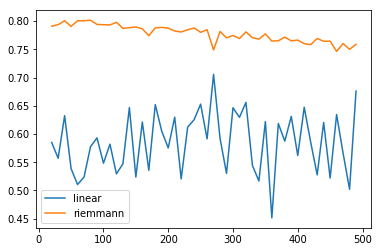

In [21]:
import matplotlib.pyplot as plt
plt.plot(tab_trail,result_acc_linear,label="linear")
plt.plot(tab_trail,result_acc_riemmann,label="riemmann")
plt.legend()
plt.show()

In [25]:
donnees=[]
labels=[]
for k in range(1,3):
    donnees_tmp,labels_tmp = file_to_data("data/subject_0"+str(k)+".mat")
    donnees+=donnees_tmp
    labels+=labels_tmp

In [ ]:
#512 Hz
#On prend 52 trial par échantillon pour avoir un temps de reaction d'environ 0,1015625s
#On supprime les derniers echantillons pour avoir un multiple de 52 et donc des matrices completes
tab_trail=[]
result_acc_linear=[]
result_acc_riemmann=[]
for mult in range(2,50):
    nb_trail=mult*10
    print(nb_trail)
    acc = cross_val_linear(donnees,labels,nb_trail)
    print("accuracy linear : "+str(acc))
    tab_trail.append(nb_trail)
    result_acc_linear.append(acc)
    acc = cross_val_riemann(donnees,labels,nb_trail)
    result_acc_riemmann.append(acc)
    print("accuracy riemann : "+str(acc))

20
accuracy linear : 0.4818780876945835
(15172,)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(tab_trail,result_acc_linear,label="linear")
plt.plot(tab_trail,result_acc_riemmann,label="riemmann")
plt.legend()
plt.show()